This notebook contains BDT variables' distribution from major background

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
datasets_=json.load(open('../Samples/backgrounds_nonempty.json'))
scales_=json.load(open('../Samples/backgrounds_scale.json'))

# flatten datasets
datasets = {}
for group in datasets_:
    for tag in datasets_[group]:
        files = datasets_[group][tag]
        datasets[tag] = {'files': files, 'treename': 'ffNtuplizer/ffNtuple'}

# flatten scales
scales = {}
for group in scales_:
    for tag in scales_[group]:
        scales[tag] = scales_[group][tag]

lumi = 60.432*1e3
for k in scales:
    scales[k] *= lumi

# mapping
mapping = {}
for k in datasets_: mapping[k] = list(datasets_[k])

### Let's plot all leptonJets pT (and multiplicity) first

In [6]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", 80, 0, 800)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "pt": hist.Hist("#counts/10GeV", dataset_axis, pt_axis)
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
        
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        wnlo = np.ones_like(df.size)
        if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
            genparticles = JaggedCandidateArray.candidatesfromcounts(
                df['gen_p4'],
                px=df['gen_p4.fCoordinates.fX'],
                py=df['gen_p4.fCoordinates.fY'],
                pz=df['gen_p4.fCoordinates.fZ'],
                energy=df['gen_p4.fCoordinates.fT'],
                pid=df['gen_pid'],
            )
            gentops = genparticles[np.abs(genparticles.pid)==6]
            genws = genparticles[np.abs(genparticles.pid)==24]
            genzs = genparticles[np.abs(genparticles.pid)==23]

            if 'TTJets' in dataset:
                wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
            elif 'WJets' in dataset:
                wnlo = self.nlo_w(genws[0].p4.pt.sum())
            elif 'DYJets' in dataset:
                wnlo = self.nlo_z(genzs[0].p4.pt.sum())
        wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output

        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leptonjets_ = dileptonjets[controlregion.flatten()]
        wgt = wgt[controlregion.flatten()]

        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt)
        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=(leptonjets_.pt.ones_like()*wgt).flatten())
        
        return output
    
    def postprocess(self, accumulator):
        # scale
        accumulator['multi'].scale(scales, axis='dataset')
        accumulator['pt'].scale(scales, axis='dataset')
        # cat grouping
        accumulator['multi_cat'] = accumulator['multi'].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        accumulator['pt_cat'] = accumulator['pt'].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        
        return accumulator

In [7]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 4302/4302 [11:35<00:00,  6.19items/s] 


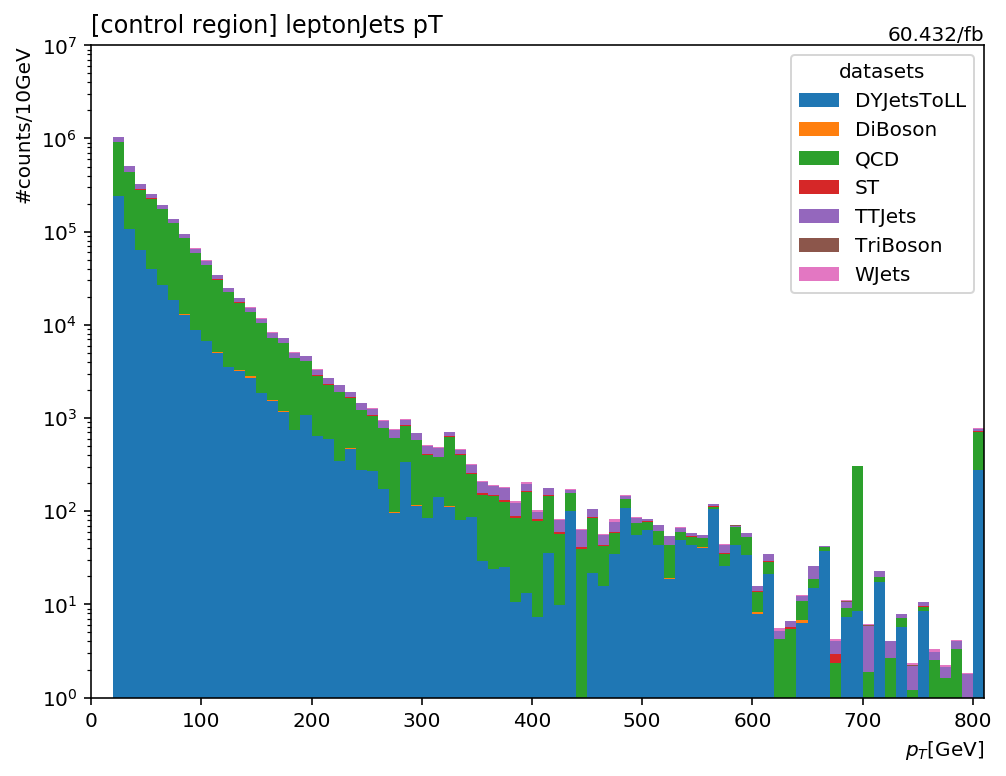

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['pt_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

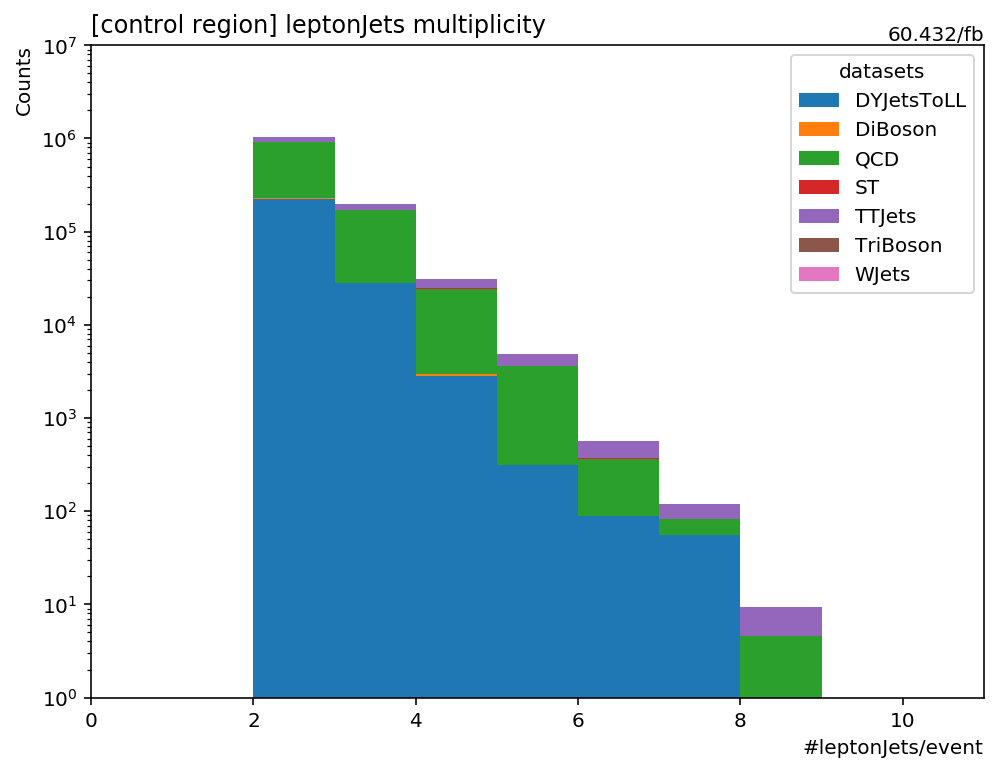

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['multi_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets multiplicity', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [10]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1.001)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 200)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 500)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis),
            "ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis),
            "ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        wnlo = np.ones_like(df.size)
        if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
            genparticles = JaggedCandidateArray.candidatesfromcounts(
                df['gen_p4'],
                px=df['gen_p4.fCoordinates.fX'],
                py=df['gen_p4.fCoordinates.fY'],
                pz=df['gen_p4.fCoordinates.fZ'],
                energy=df['gen_p4.fCoordinates.fT'],
                pid=df['gen_pid'],
            )
            gentops = genparticles[np.abs(genparticles.pid)==6]
            genws = genparticles[np.abs(genparticles.pid)==24]
            genzs = genparticles[np.abs(genparticles.pid)==23]

            if 'TTJets' in dataset:
                wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
            elif 'WJets' in dataset:
                wnlo = self.nlo_w(genws[0].p4.pt.sum())
            elif 'DYJets' in dataset:
                wnlo = self.nlo_z(genzs[0].p4.pt.sum())
        wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0)
        maxd0_ = absd0.max()
        mind0_ = absd0.min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        
        # control region selections
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()

        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output

        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leptonjets_ = dileptonjets[controlregion.flatten()]
        wgt = wgt[controlregion.flatten()]

        wgt_ = (leptonjets_.pt.ones_like()*wgt).flatten()
        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgt_)
        output['eta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), weight=wgt_)
        output['nef'].fill(dataset=dataset, nef=leptonjets_.nef.flatten(), weight=wgt_)
        output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten(), weight=wgt_)
        output['mind0'].fill(dataset=dataset, mind0=leptonjets_.mind0.flatten(), weight=wgt_)
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten(), weight=wgt_)
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(), weigth=wgt_)
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten(), weight=wgt_)
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten(), weight=wgt_)
        output['lamb'].fill(dataset=dataset, lamb=leptonjets_.lamb.flatten(), weight=wgt_)
        output['epsi'].fill(dataset=dataset, epsi=leptonjets_.epsi.flatten(), weight=wgt_)
        output['ecfe1'].fill(dataset=dataset, ecfe1=leptonjets_.ecf1.flatten(), weight=wgt_)
        output['ecfe2'].fill(dataset=dataset, ecfe2=leptonjets_.ecf2.flatten(), weight=wgt_)
        output['ecfe3'].fill(dataset=dataset, ecfe3=leptonjets_.ecf3.flatten(), weight=wgt_)
        output['mva'].fill(dataset=dataset, mva=leptonjets_.mva.flatten(), weight=wgt_)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        # scale
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
        # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [11]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 4302/4302 [15:38<00:00,  2.53s/items] 


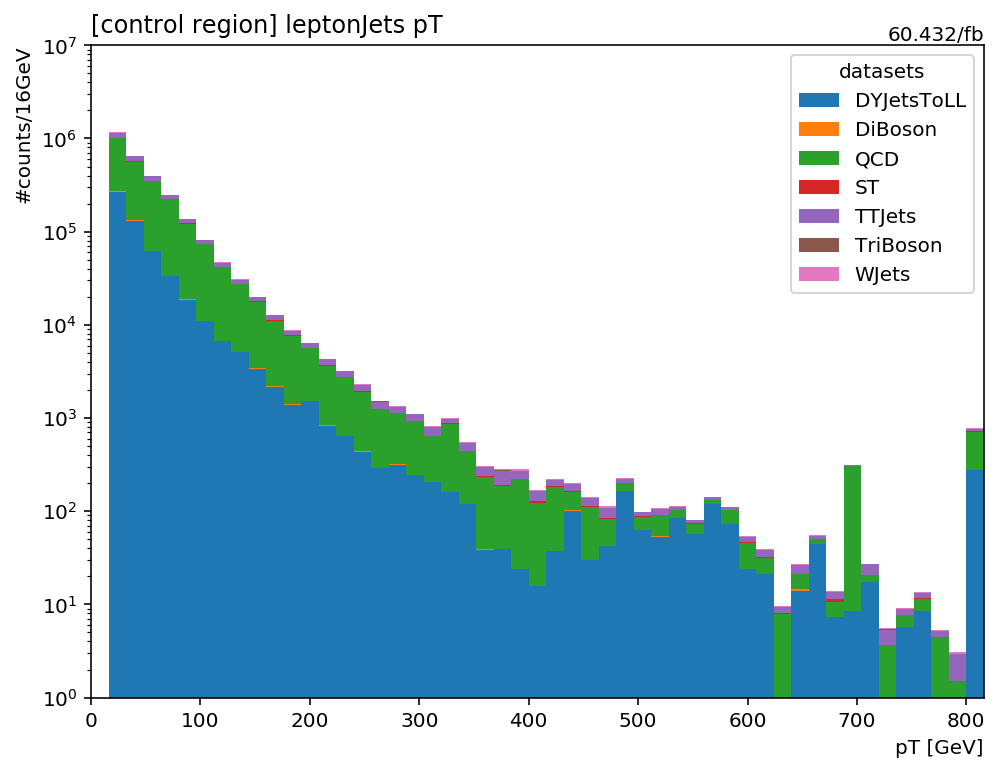

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['pt_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

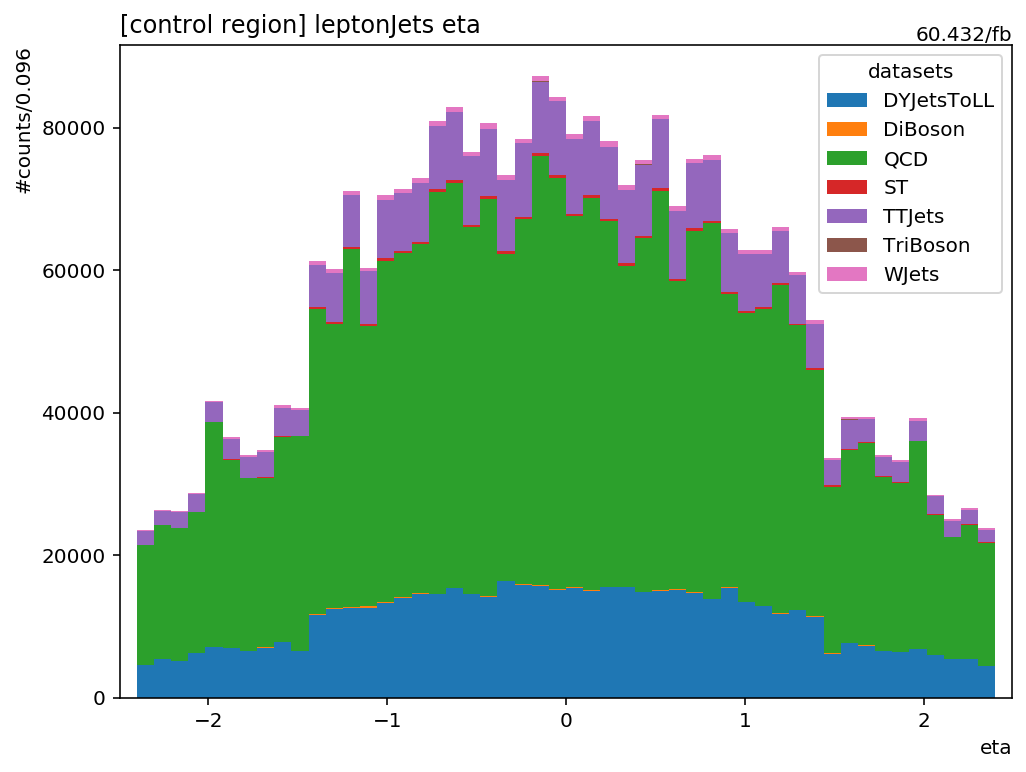

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['eta_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets eta', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

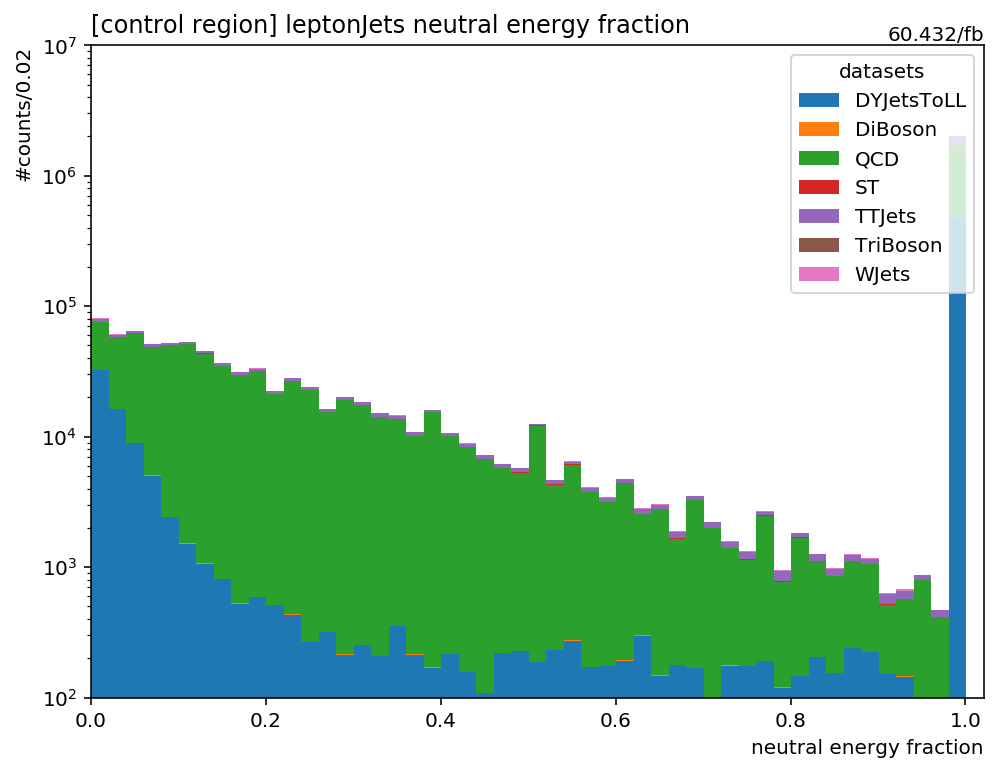

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['nef_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1e2, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets neutral energy fraction', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

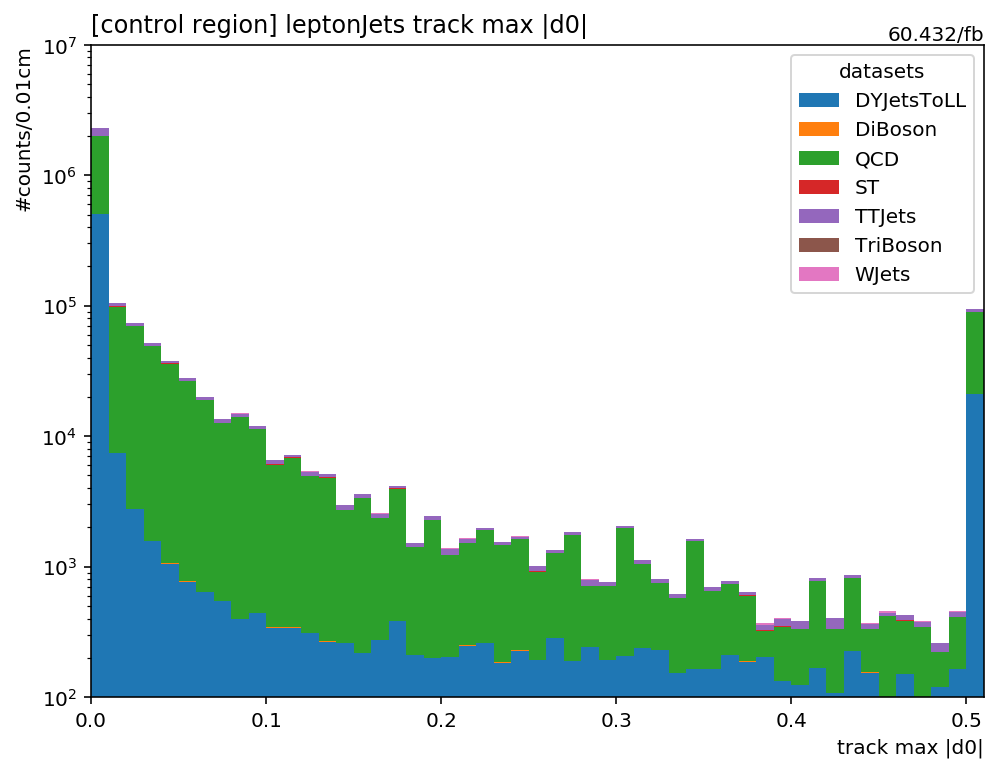

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['maxd0_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1e2, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets track max |d0|', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

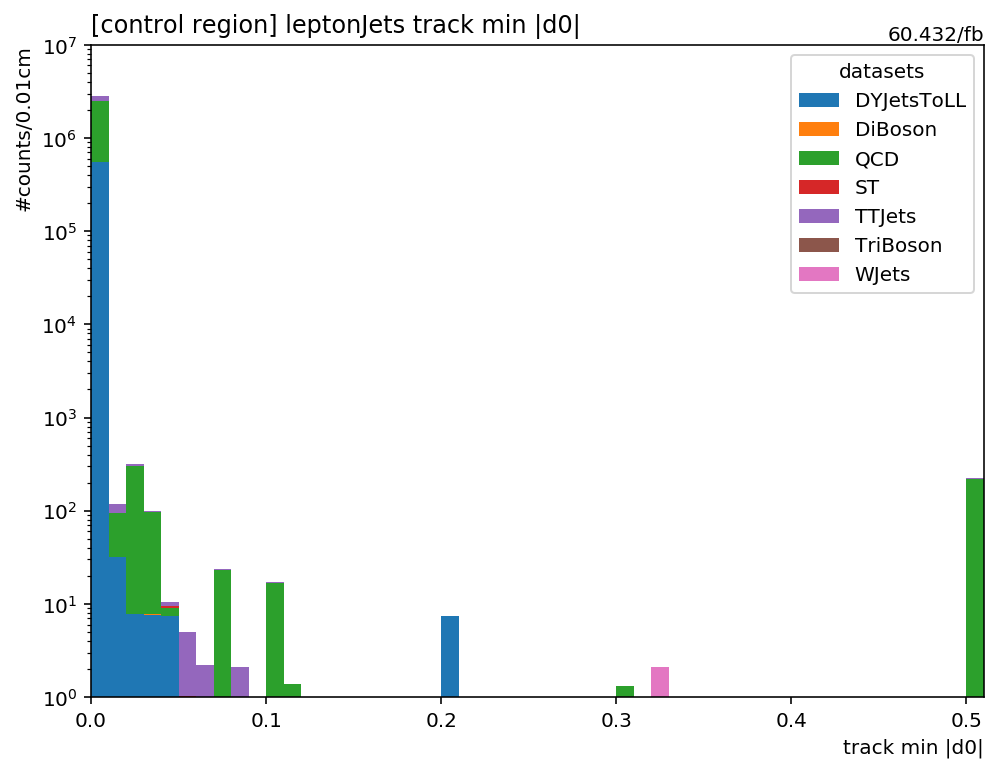

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mind0_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets track min |d0|', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

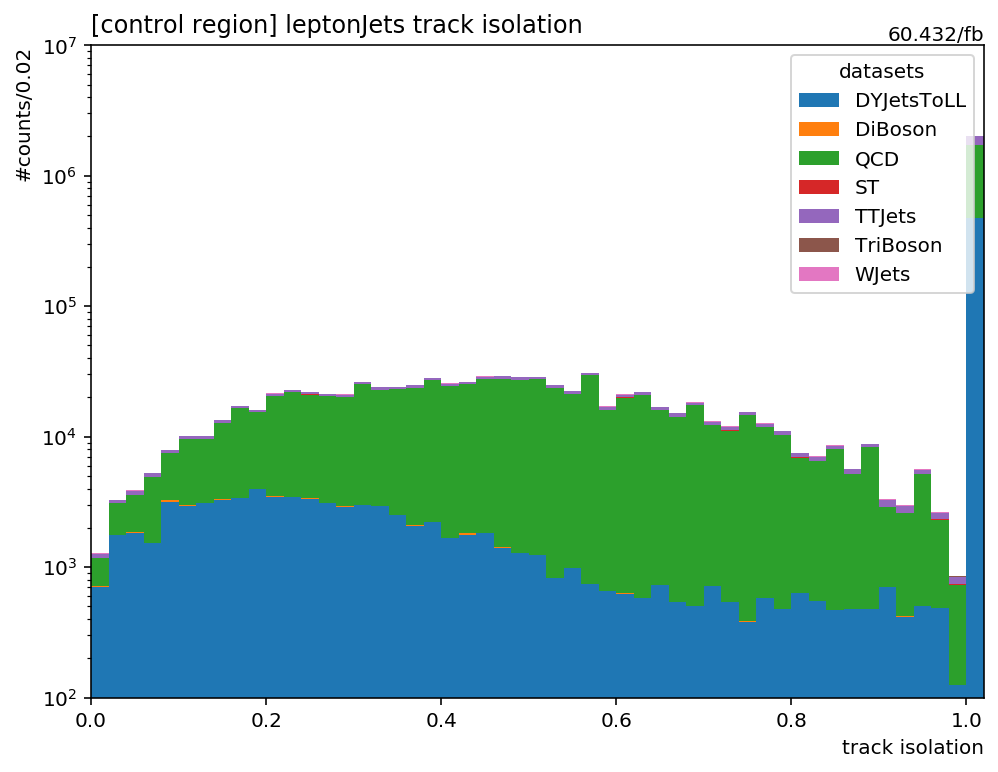

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['tkiso_cat'], overlay='cat', stack=True, ax=ax, overflow='over')
ax.set_yscale('log')
ax.set_ylim([1e2, 1e7])
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets track isolation', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

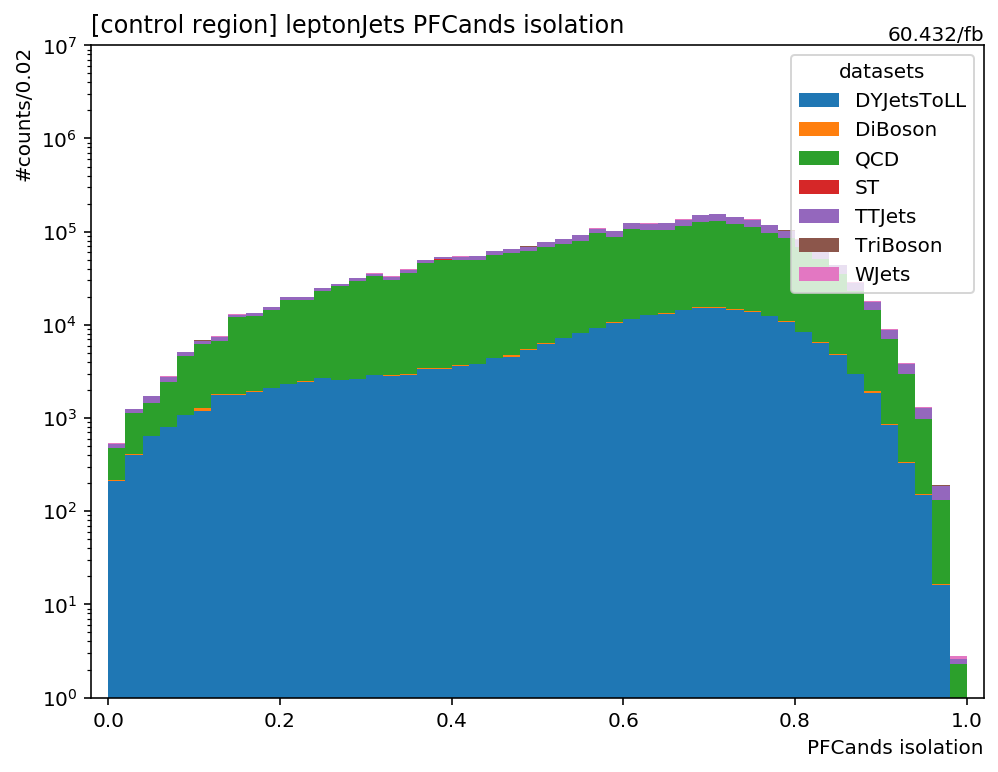

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['pfiso_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_title('[control region] leptonJets PFCands isolation', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

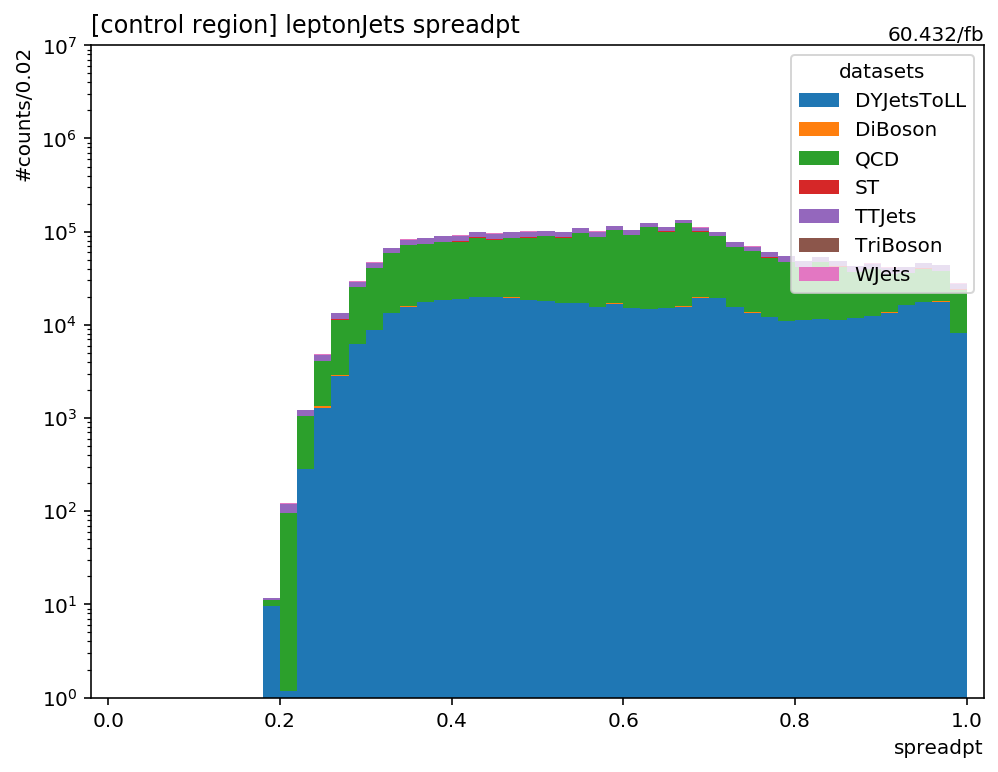

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['spreadpt_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_title('[control region] leptonJets spreadpt', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

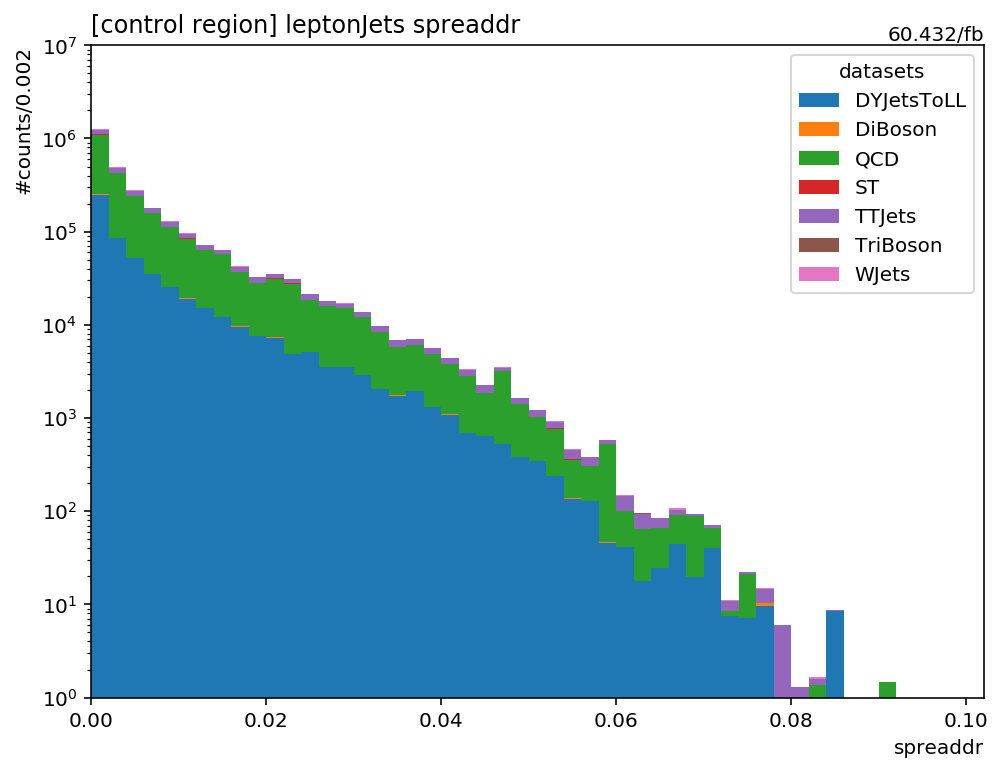

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['spreaddr_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_title('[control region] leptonJets spreaddr', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

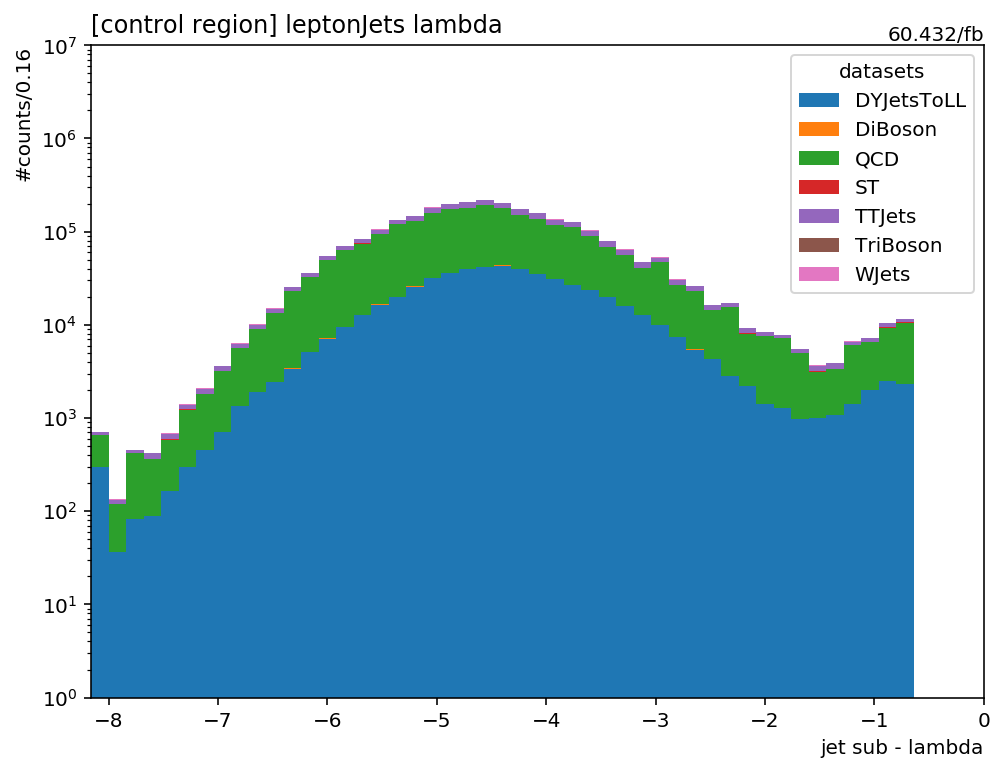

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['lamb_cat'], overlay='cat', stack=True, ax=ax, overflow='under')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_title('[control region] leptonJets lambda', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

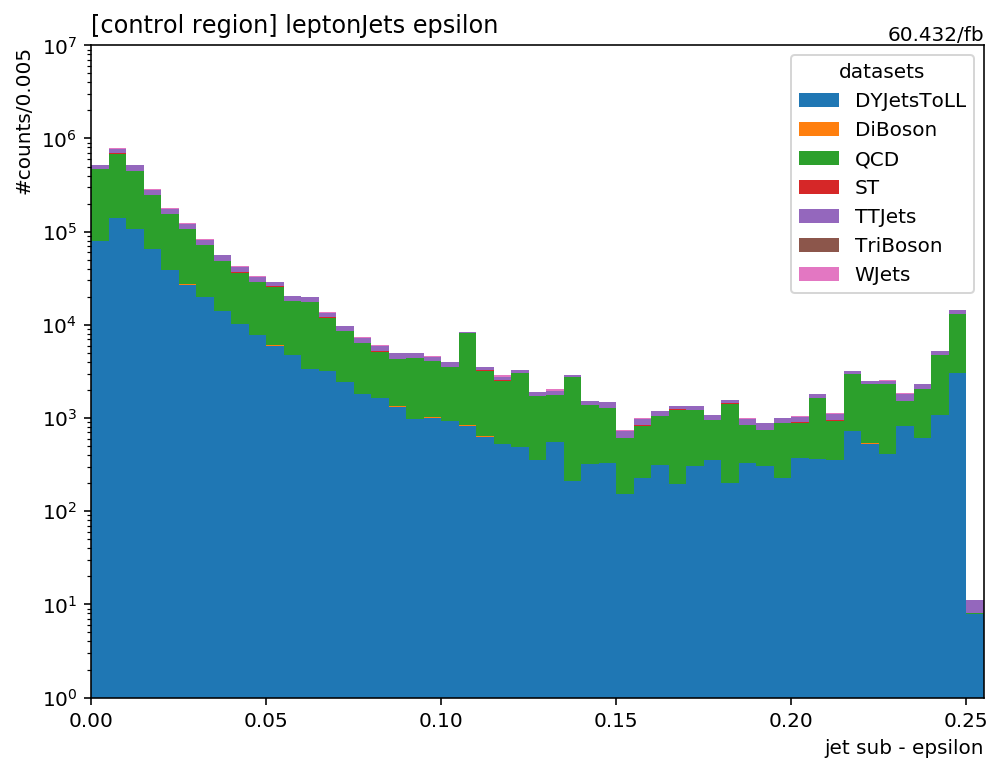

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['epsi_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_title('[control region] leptonJets epsilon', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

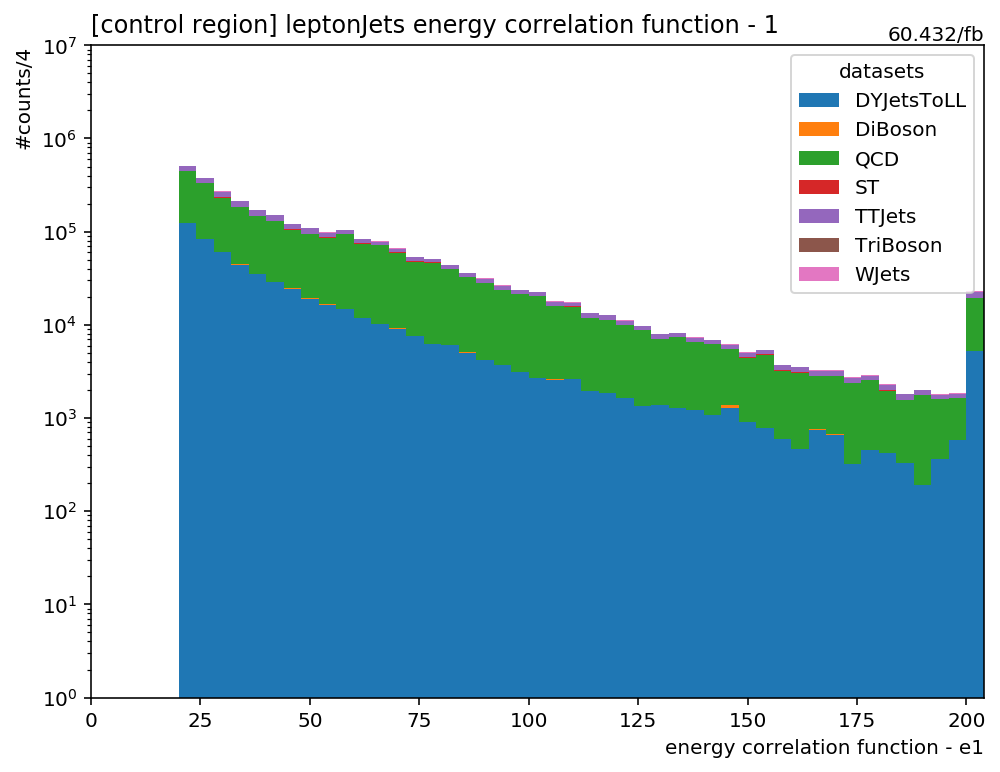

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['ecfe1_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_title('[control region] leptonJets energy correlation function - 1', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

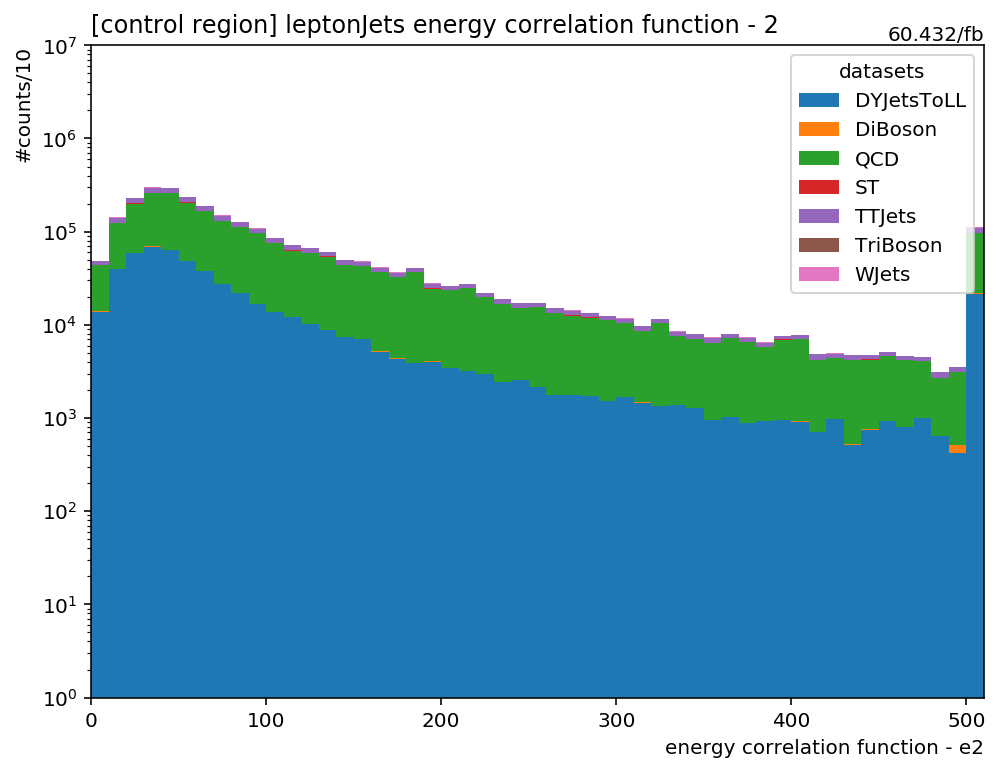

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['ecfe2_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_title('[control region] leptonJets energy correlation function - 2', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

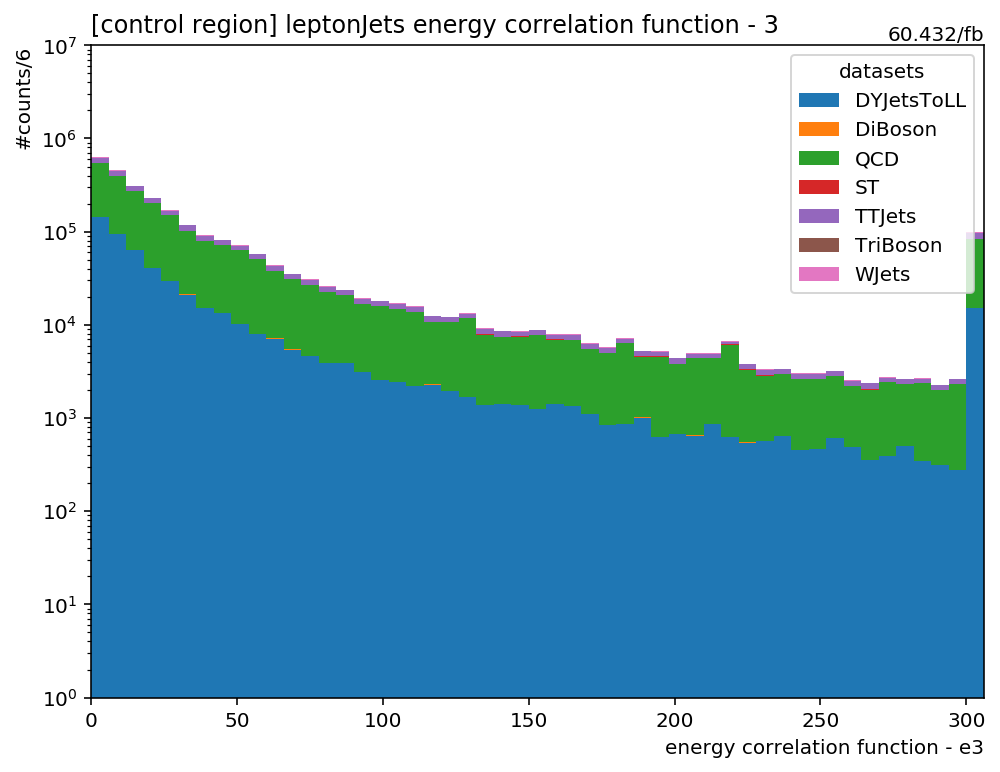

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['ecfe3_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_title('[control region] leptonJets energy correlation function - 3', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

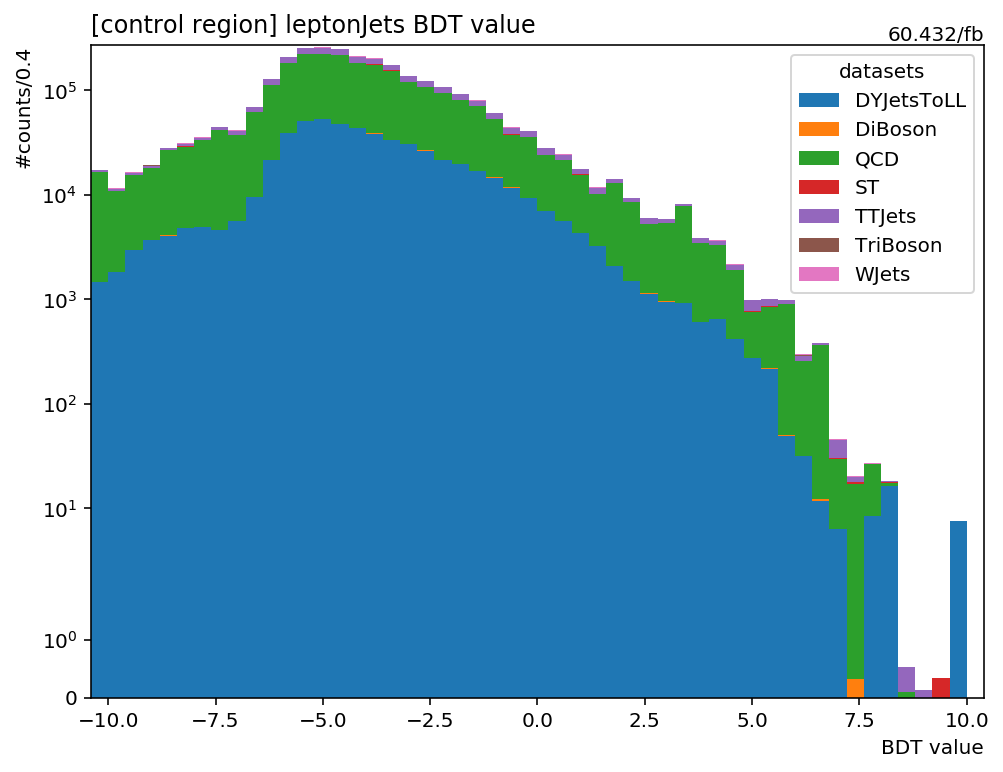

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mva_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJets BDT value', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_yscale('symlog')
ax.set_ylim([0, None]);

### leptonJet pair
- invariant mass
- delta phi

In [27]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        mass_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 500)
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("#counts/10GeV", dataset_axis, mass_axis),
            'dphi': hist.Hist("#counts/$\pi$/50", dataset_axis, dphi_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        wnlo = np.ones_like(df.size)
        if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
            genparticles = JaggedCandidateArray.candidatesfromcounts(
                df['gen_p4'],
                px=df['gen_p4.fCoordinates.fX'],
                py=df['gen_p4.fCoordinates.fY'],
                pz=df['gen_p4.fCoordinates.fZ'],
                energy=df['gen_p4.fCoordinates.fT'],
                pid=df['gen_pid'],
            )
            gentops = genparticles[np.abs(genparticles.pid)==6]
            genws = genparticles[np.abs(genparticles.pid)==24]
            genzs = genparticles[np.abs(genparticles.pid)==23]

            if 'TTJets' in dataset:
                wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
            elif 'WJets' in dataset:
                wnlo = self.nlo_w(genws[0].p4.pt.sum())
            elif 'DYJets' in dataset:
                wnlo = self.nlo_z(genzs[0].p4.pt.sum())
        wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leadingLjPair_ = leadingLjPair[controlregion]
        wgt=wgt[controlregion.flatten()]
        dphi_ = np.abs(leadingLjPair_.i0.p4.delta_phi(leadingLjPair_.i1.p4))

        output['mass'].fill(dataset=dataset, mass=leadingLjPair_.mass.flatten(), weight=wgt)
        output['dphi'].fill(dataset=dataset, dphi=dphi_.flatten(), weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        # scale
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
        # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [28]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 4302/4302 [13:39<00:00,  3.66items/s] 


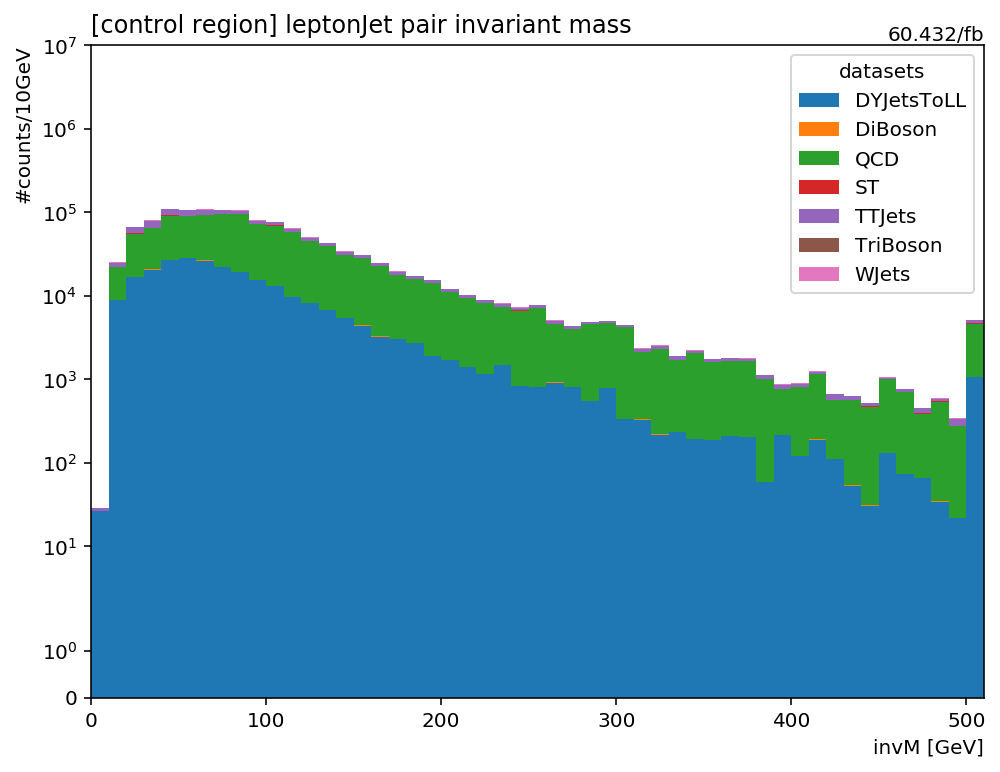

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mass_cat'], overlay='cat', stack=True, ax=ax, overflow='over')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_yscale('symlog')
ax.set_ylim([0, 1e7])
ax.set_title('[control region] leptonJet pair invariant mass', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

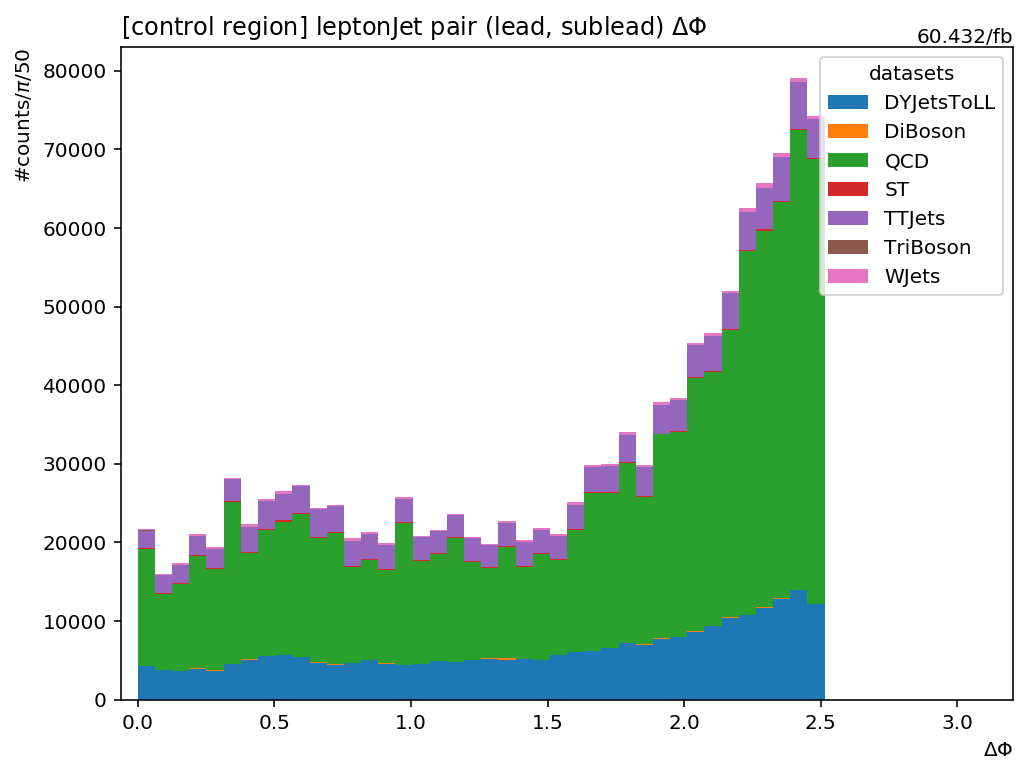

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['dphi_cat'], overlay='cat', stack=True, ax=ax, overflow='all')

ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJet pair (lead, sublead) $\Delta\Phi$', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### leptonJets count passing BDT thresholds

In [29]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "control region")
        count_axis = hist.Bin("count", "#pass BDT threshold", 9, 0, 9)
        self._accumulator = processor.dict_accumulator({
            'count': hist.Hist("Counts", dataset_axis, count_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            mva=df['pfjet_mva'],
        )
        wgt = df['weight']
        ## apply MET filters ##
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt=wgt[metfiltermask][twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
            leadingLjPair = leadingLjPair[controlregion]
            wgt=wgt[controlregion.flatten()]
            looseval = 2.3958024978637695
            mediumval = 5.316260814666748
            tightval = 7.421047687530518
            passloosecounts = (leadingLjPair.i0.mva>looseval).astype(int)+(leadingLjPair.i1.mva>looseval).astype(int)
            passmediumcounts = (leadingLjPair.i0.mva>mediumval).astype(int)+(leadingLjPair.i1.mva>mediumval).astype(int)
            passtightcounts = (leadingLjPair.i0.mva>tightval).astype(int)+(leadingLjPair.i1.mva>tightval).astype(int)
            
            output['count'].fill(dataset=dataset, count=passloosecounts.flatten(), weight=wgt)
            output['count'].fill(dataset=dataset, count=(passmediumcounts.flatten()+3), weight=wgt)
            output['count'].fill(dataset=dataset, count=(passtightcounts.flatten()+6), weight=wgt)

        return output
    
    def postprocess(self, accumulator):
        # scale
        accumulator['count'].scale(scales, axis='dataset')
        # cat grouping
        accumulator['count_cat'] = accumulator['count'].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [30]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 4987/4987 [03:29<00:00, 23.83items/s]


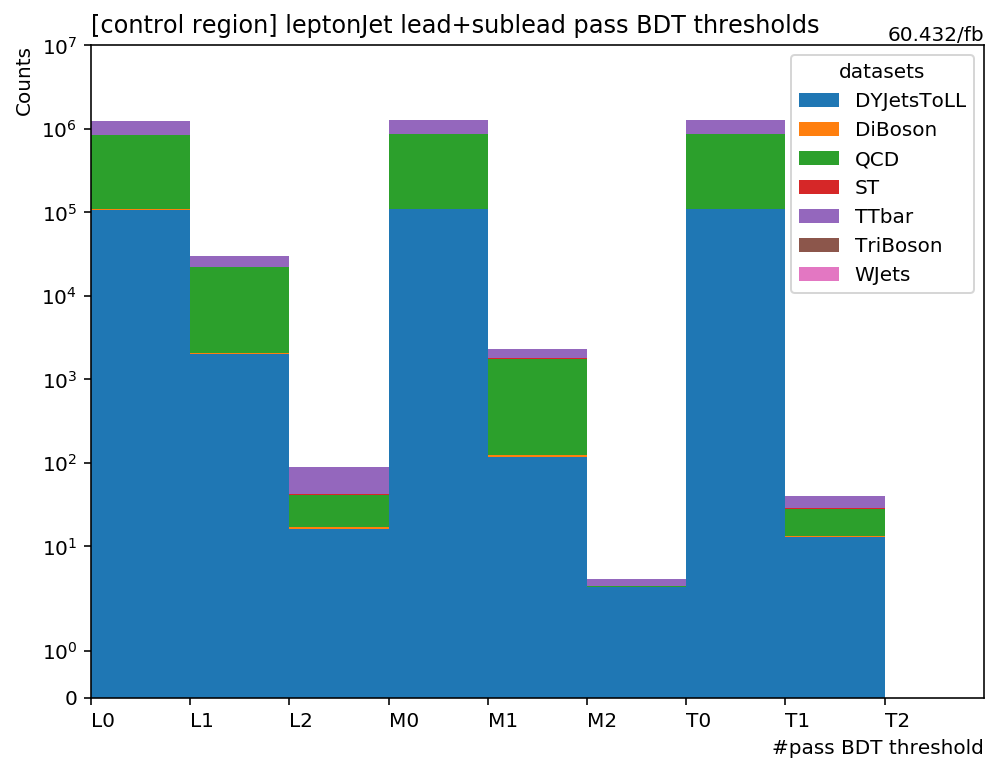

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['count_cat'], overlay='cat', stack=True, ax=ax)

ax.set_ylim([0, 1e7])
ax.set_yscale('symlog')
ax.set_xticks(list(range(9)))
ax.set_xticklabels(['L0', 'L1', 'L2', 'M0', 'M1', 'M2', 'T0', 'T1', 'T2'],fontdict={'ha': 'left'})
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region] leptonJet lead+sublead pass BDT thresholds', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

---